"""
Improved Disease Prediction using Microbiome Data

Key Improvements:
1. XGBoost-only approach (removed PyCaret)
2. Both PCA and UMAP visualizations
3. Enhanced feature selection with multiple methods
4. Class balancing via random subsampling of healthy controls
5. Cross-validation with stratified folds
6. Feature importance analysis
7. Better evaluation metrics and visualization
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score, 
                             precision_score, f1_score, cohen_kappa_score,
                             matthews_corrcoef, confusion_matrix, classification_report)
from scipy.stats import zscore, kruskal, mannwhitneyu
from tqdm import tqdm
import random
import warnings
import xgboost as xgb
import umap

warnings.filterwarnings('ignore')

/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*80)
print("MICROBIOME DISEASE CLASSIFICATION - IMPROVED VERSION")
print("="*80)

MICROBIOME DISEASE CLASSIFICATION - IMPROVED VERSION


In [6]:
# Download abundance data from GMrepo

import os
import urllib.request

# List of files to download with their URLs
files_to_download = [
    ("superkingdom2descendents.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "taxonomy table"),
    ("samples_loaded.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "sample table"),
    ("sample_to_run_info.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample run"),
    ("species_abundance.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "abundance table")
]

for filename, url, description in files_to_download:
    if not os.path.exists(filename):
        print(f"Downloading {description}...")
        urllib.request.urlretrieve(url, filename)
        print(f"{description} download finished")
    else:
        print(f"{filename} already exists, skipping download")

taxonomy table download finished
sample table download finished
sample run download finished
abundance table download finished


In [8]:
import gzip
import shutil

def decompress_gz(gz_file):
    """Decompress a .gz file"""
    output_file = gz_file.replace('.gz', '')
    
    with gzip.open(gz_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed: {gz_file} -> {output_file}")

# List of files to decompress
files_to_decompress = [
    "superkingdom2descendents.txt.gz",
    "samples_loaded.txt.gz",
    "sample_to_run_info.txt.gz",
    "species_abundance.txt.gz"
]

for file in files_to_decompress:
    decompress_gz(file)

Decompressed: superkingdom2descendents.txt.gz -> superkingdom2descendents.txt
Decompressed: samples_loaded.txt.gz -> samples_loaded.txt
Decompressed: sample_to_run_info.txt.gz -> sample_to_run_info.txt
Decompressed: species_abundance.txt.gz -> species_abundance.txt


In [9]:
# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[1/8] Loading data...")

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype='str')

print(f"✓ Loaded {len(abundance_raw)} abundance records")
print(f"✓ Loaded {len(taxonomy_table)} taxonomy entries")
print(f"✓ Loaded {len(sample_table)} samples")



[1/8] Loading data...
✓ Loaded 5541271 abundance records
✓ Loaded 5195 taxonomy entries
✓ Loaded 108176 samples


In [24]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n[2/8] Preprocessing abundance data...")

# Filter to genus level
abundance_genus = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

# Pivot table: samples as rows, taxa as columns
pivoted_df = abundance_genus.pivot_table(
    index='loaded_uid', 
    columns='ncbi_taxon_id', 
    values='relative_abundance', 
    fill_value=0
)

# Rename columns with genus names
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))
pivoted_df.rename(columns=mapping, inplace=True)

# Replace [, ], < with _ in all column names
pivoted_df.columns = pivoted_df.columns.str.replace(r'[\[\]<]', '_', regex=True)

print(f"✓ Created abundance matrix: {pivoted_df.shape}")



[2/8] Preprocessing abundance data...
✓ Created abundance matrix: (68723, 2214)


In [25]:
# ============================================================================
# 3. METADATA CLEANING
# ============================================================================
print("\n[3/8] Cleaning metadata...")

# Merge metadata tables
metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

# Quality filters
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]
print(f"  - Removed {len(metadata_df[metadata_df['QCStatus'] == 0])} low-quality samples")

# Remove phenotypes with < 100 samples
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]
print(f"  - Kept {len(phenotypes_to_keep)} phenotypes with ≥100 samples")

# Standardize phenotype names
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['healthy', 'Health', 'Normal'], 'Healthy'
)
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease'
)

# Remove duplicates
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])
duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]
print(f"  - Removed {duplicated_rows.sum()} duplicate rows")



[3/8] Cleaning metadata...
  - Removed 0 low-quality samples
  - Kept 64 phenotypes with ≥100 samples
  - Removed 0 duplicate rows


In [26]:
# ============================================================================
# 4. ABUNDANCE DATA CLEANING
# ============================================================================
print("\n[4/8] Cleaning abundance data...")

# Keep only samples in metadata
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[pivoted_df.index.isin(uids_to_keep)]

# Remove unknown column (first column)
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

# Verify alignment
metadata_df = metadata_df.set_index('uid').loc[pivoted_df_filtered.index].reset_index()
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)
metadata_df = metadata_df.reset_index(drop=True)

print(f"✓ Final dataset: {len(pivoted_df_filtered)} samples × {len(pivoted_df_filtered.columns)} features")



[4/8] Cleaning abundance data...
✓ Final dataset: 57391 samples × 2213 features


In [27]:
# ============================================================================
# 5. HEALTHY SAMPLES - OUTLIER REMOVAL
# ============================================================================
print("\n[5/8] Processing healthy samples and removing outliers...")

# Subset healthy samples
healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"].copy()
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index].copy()

# Reset indices to align
pivoted_df_Healthy = pivoted_df_Healthy.reset_index(drop=True)
healthy_metadata = healthy_metadata.reset_index(drop=True)

# Standardize and perform PCA
scaler = StandardScaler()
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(healthy_standardized)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Identify outliers using Z-scores
z_scores = zscore(pca_df)
outlier_threshold = 3
outliers = (np.abs(z_scores) > outlier_threshold).any(axis=1)

print(f"  - Identified {outliers.sum()} outliers in healthy samples")

# Remove outliers
pivoted_df_Healthy = pivoted_df_Healthy[~outliers].reset_index(drop=True)
healthy_metadata = healthy_metadata[~outliers].reset_index(drop=True)

print(f"✓ Clean healthy samples: {len(pivoted_df_Healthy)}")



[5/8] Processing healthy samples and removing outliers...
  - Identified 36 outliers in healthy samples
✓ Clean healthy samples: 29558



[6/8] Creating visualizations...
  - Computing UMAP (this may take a few minutes)...
✓ Saved: healthy_samples_pca_umap.png


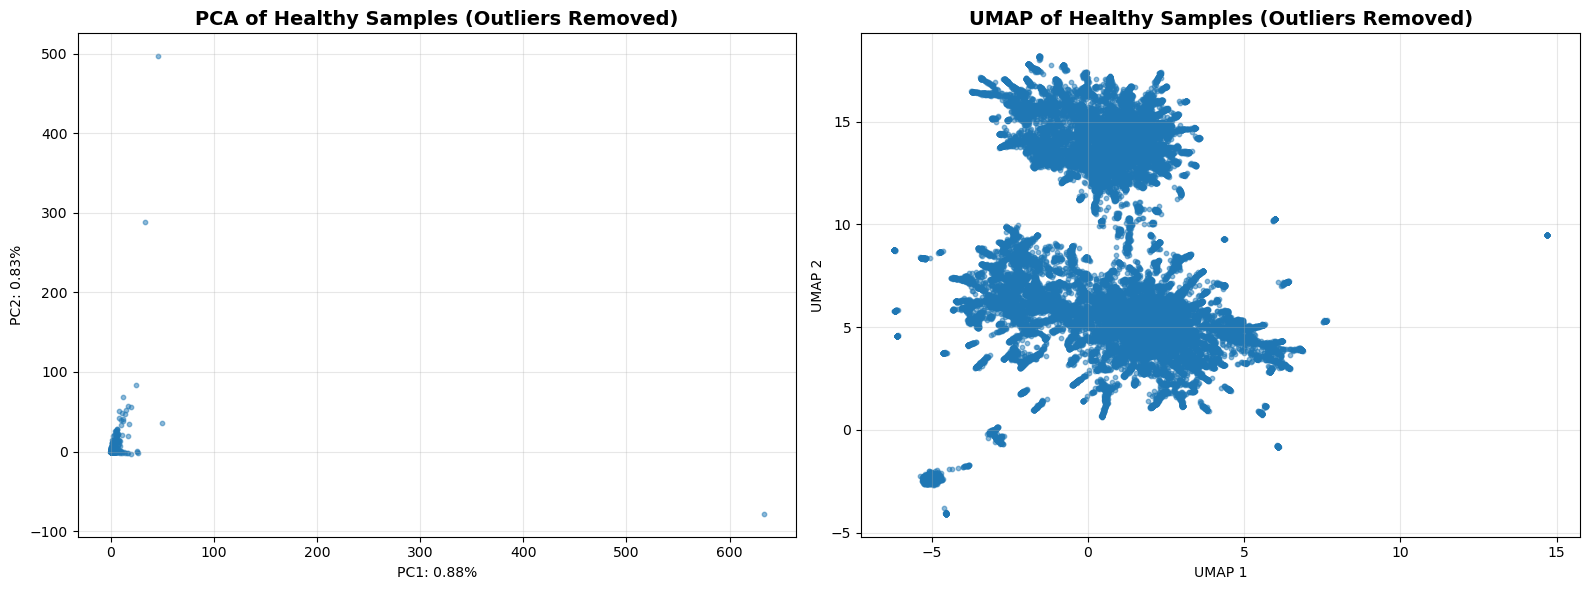

In [28]:
# ============================================================================
# 6. VISUALIZATION - HEALTHY SAMPLES (PCA + UMAP)
# ============================================================================
print("\n[6/8] Creating visualizations...")

# Re-standardize after outlier removal
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(healthy_standardized)

# UMAP
print("  - Computing UMAP (this may take a few minutes)...")
umap_reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
umap_result = umap_reducer.fit_transform(healthy_standardized)

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=10)
axes[0].set_title('PCA of Healthy Samples (Outliers Removed)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
axes[0].set_ylabel(f'PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5, s=10)
axes[1].set_title('UMAP of Healthy Samples (Outliers Removed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('healthy_samples_pca_umap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: healthy_samples_pca_umap.png")


In [29]:
# ============================================================================
# 7. DISEASE CLASSIFICATION LOOP
# ============================================================================
print("\n[7/8] Training disease classifiers...")

# Separate disease samples
non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"].reset_index(drop=True)
pivoted_df_non_Healthy = pivoted_df_filtered.loc[metadata_df[metadata_df["phenotype"] != "Healthy"].index].reset_index(drop=True)

# Storage for results
all_results = []
feature_importance_dict = {}

# Get list of diseases
diseases = non_healthy_metadata['phenotype'].unique()
print(f"\nProcessing {len(diseases)} diseases...")

for disease in tqdm(diseases, desc="Disease classification"):
    
    print(f"\n{'='*80}")
    print(f"Processing: {disease}")
    print(f"{'='*80}")
    
    # ========================================================================
    # 7.1 Subset disease samples
    # ========================================================================
    is_disease = non_healthy_metadata['phenotype'] == disease
    disease_data = pivoted_df_non_Healthy[is_disease].copy().reset_index(drop=True)
    disease_labels = non_healthy_metadata[is_disease].copy().reset_index(drop=True)
    
    n_disease = len(disease_data)
    n_healthy = len(pivoted_df_Healthy)
    
    print(f"  Disease samples: {n_disease}")
    print(f"  Healthy samples: {n_healthy}")
    
    # ========================================================================
    # 7.2 Balance classes by subsampling healthy controls
    # ========================================================================
    # Randomly subsample healthy samples to match disease sample count
    healthy_indices = np.random.choice(
        len(pivoted_df_Healthy), 
        size=n_disease, 
        replace=False
    )
    
    balanced_healthy_data = pivoted_df_Healthy.iloc[healthy_indices].copy().reset_index(drop=True)
    balanced_healthy_labels = healthy_metadata.iloc[healthy_indices].copy().reset_index(drop=True)
    
    print(f"  Balanced healthy samples: {len(balanced_healthy_data)}")
    print(f"  ✓ Classes balanced (1:1 ratio)")
    
    # ========================================================================
    # 7.3 Feature selection using multiple methods
    # ========================================================================
    print("  Performing feature selection...")
    
    # Convert columns to list to ensure proper iteration
    column_list = list(pivoted_df_Healthy.columns)
    
    # Method 1: Kruskal-Wallis test (univariate non-parametric)
    kw_features = []
    kw_pvalues = []
    
    for col in column_list:
        # Check for sufficient variance
        try:
            healthy_unique = len(balanced_healthy_data[col].unique())
            disease_unique = len(disease_data[col].unique())
            if healthy_unique > 1 and disease_unique > 1:
                _, p_value = kruskal(balanced_healthy_data[col], disease_data[col])
                if p_value < 0.05:
                    kw_features.append(col)
                    kw_pvalues.append(p_value)
        except:
            continue
    
    # Method 2: Mann-Whitney U test (more robust for small samples)
    mw_features = []
    mw_pvalues = []
    
    for col in column_list:
        try:
            healthy_unique = len(balanced_healthy_data[col].unique())
            disease_unique = len(disease_data[col].unique())
            if healthy_unique > 1 and disease_unique > 1:
                _, p_value = mannwhitneyu(balanced_healthy_data[col], disease_data[col], alternative='two-sided')
                if p_value < 0.05:
                    mw_features.append(col)
                    mw_pvalues.append(p_value)
        except:
            continue
    
    # Combine features from both methods (union)
    selected_features = list(set(kw_features) | set(mw_features))
    
    # If too many features, select top N by combined p-value ranking
    MAX_FEATURES = 500
    if len(selected_features) > MAX_FEATURES:
        # Create combined p-value ranking
        feature_scores = {}
        for feat in selected_features:
            kw_p = kw_pvalues[kw_features.index(feat)] if feat in kw_features else 1.0
            mw_p = mw_pvalues[mw_features.index(feat)] if feat in mw_features else 1.0
            feature_scores[feat] = min(kw_p, mw_p)  # Take best p-value
        
        # Select top features
        selected_features = sorted(feature_scores.keys(), key=lambda x: feature_scores[x])[:MAX_FEATURES]
    
    print(f"  Selected features: {len(selected_features)}")
    
    # If no significant features found, use top 100 by variance
    if len(selected_features) < 10:
        print("  Warning: Few significant features found, using top variance features")
        combined_data = pd.concat([balanced_healthy_data, disease_data])
        variances = combined_data.var()
        selected_features = variances.nlargest(100).index.tolist()
    
    # Filter data to selected features
    balanced_healthy_filtered = balanced_healthy_data[selected_features].copy()
    disease_filtered = disease_data[selected_features].copy()
    
    # ========================================================================
    # 7.4 Combine and prepare data
    # ========================================================================
    X = pd.concat([balanced_healthy_filtered, disease_filtered]).reset_index(drop=True)
    y_labels = pd.concat([balanced_healthy_labels, disease_labels])['phenotype'].reset_index(drop=True)
    y = (y_labels != "Healthy").astype(int)  # Binary: 0=Healthy, 1=Disease
    
    print(f"  Final dataset shape: {X.shape}")
    print(f"  Class distribution: Healthy={sum(y==0)}, {disease}={sum(y==1)}")
    
    # ========================================================================
    # 7.5 Visualizations (PCA + UMAP)
    # ========================================================================
    scaler_viz = StandardScaler()
    X_scaled = scaler_viz.fit_transform(X)
    
    # PCA
    pca_viz = PCA(n_components=2)
    pca_coords = pca_viz.fit_transform(X_scaled)
    
    # UMAP
    umap_viz = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
    umap_coords = umap_viz.fit_transform(X_scaled)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['#2E86AB' if label == 0 else '#A23B72' for label in y]
    labels_str = ['Healthy' if label == 0 else disease for label in y]
    
    # PCA
    for label_val, label_str, color in zip([0, 1], ['Healthy', disease], ['#2E86AB', '#A23B72']):
        mask = y == label_val
        axes[0].scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
                       c=color, label=label_str, alpha=0.6, s=30)
    axes[0].set_title(f'PCA: Healthy vs {disease}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(f'PC1: {pca_viz.explained_variance_ratio_[0]*100:.2f}%')
    axes[0].set_ylabel(f'PC2: {pca_viz.explained_variance_ratio_[1]*100:.2f}%')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # UMAP
    for label_val, label_str, color in zip([0, 1], ['Healthy', disease], ['#2E86AB', '#A23B72']):
        mask = y == label_val
        axes[1].scatter(umap_coords[mask, 0], umap_coords[mask, 1], 
                       c=color, label=label_str, alpha=0.6, s=30)
    axes[1].set_title(f'UMAP: Healthy vs {disease}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save with safe filename
    safe_disease_name = disease.replace('/', '_').replace(' ', '_')
    plt.savefig(f'{safe_disease_name}_pca_umap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ========================================================================
    # 7.6 XGBoost Training with Cross-Validation
    # ========================================================================
    print("  Training XGBoost classifier...")
    
    # Define XGBoost model with optimal parameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1'
    }
    
    cv_results = cross_validate(
        xgb_model, X, y, cv=cv, scoring=scoring, 
        return_train_score=False, n_jobs=-1
    )
    
    # Train final model on full data
    xgb_model.fit(X, y)
    
    # Get predictions
    y_pred = xgb_model.predict(X)
    y_pred_proba = xgb_model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    results = {
        'Disease': disease,
        'N_Disease': n_disease,
        'N_Healthy_Balanced': len(balanced_healthy_data),
        'N_Features': len(selected_features),
        'CV_Accuracy_Mean': cv_results['test_accuracy'].mean(),
        'CV_Accuracy_Std': cv_results['test_accuracy'].std(),
        'CV_ROC_AUC_Mean': cv_results['test_roc_auc'].mean(),
        'CV_ROC_AUC_Std': cv_results['test_roc_auc'].std(),
        'CV_Recall_Mean': cv_results['test_recall'].mean(),
        'CV_Recall_Std': cv_results['test_recall'].std(),
        'CV_Precision_Mean': cv_results['test_precision'].mean(),
        'CV_Precision_Std': cv_results['test_precision'].std(),
        'CV_F1_Mean': cv_results['test_f1'].mean(),
        'CV_F1_Std': cv_results['test_f1'].std(),
        'Train_Accuracy': accuracy_score(y, y_pred),
        'Train_ROC_AUC': roc_auc_score(y, y_pred_proba),
        'Train_Recall': recall_score(y, y_pred),
        'Train_Precision': precision_score(y, y_pred),
        'Train_F1': f1_score(y, y_pred),
        'Train_Kappa': cohen_kappa_score(y, y_pred),
        'Train_MCC': matthews_corrcoef(y, y_pred)
    }
    
    all_results.append(results)
    
    # Store feature importance
    feature_importance_dict[disease] = pd.DataFrame({
        'feature': selected_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"  ✓ CV ROC-AUC: {results['CV_ROC_AUC_Mean']:.4f} ± {results['CV_ROC_AUC_Std']:.4f}")
    print(f"  ✓ CV F1: {results['CV_F1_Mean']:.4f} ± {results['CV_F1_Std']:.4f}")


[7/8] Training disease classifiers...

Processing 62 diseases...


Disease classification:   0%|                            | 0/62 [00:00<?, ?it/s]


Processing: Obesity
  Disease samples: 383
  Healthy samples: 29558
  Balanced healthy samples: 383
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 115
  Final dataset shape: (766, 115)
  Class distribution: Healthy=383, Obesity=383
  Training XGBoost classifier...


Disease classification:   2%|▎                   | 1/62 [00:06<06:10,  6.07s/it]

  ✓ CV ROC-AUC: 0.8823 ± 0.0106
  ✓ CV F1: 0.8144 ± 0.0282

Processing: Diabetic Retinopathy
  Disease samples: 188
  Healthy samples: 29558
  Balanced healthy samples: 188
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 69
  Final dataset shape: (376, 69)
  Class distribution: Healthy=188, Diabetic Retinopathy=188
  Training XGBoost classifier...


Disease classification:   3%|▋                   | 2/62 [00:10<05:19,  5.32s/it]

  ✓ CV ROC-AUC: 0.9570 ± 0.0246
  ✓ CV F1: 0.8801 ± 0.0352

Processing: Glomerulonephritis, IGA
  Disease samples: 152
  Healthy samples: 29558
  Balanced healthy samples: 152
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 88
  Final dataset shape: (304, 88)
  Class distribution: Healthy=152, Glomerulonephritis, IGA=152
  Training XGBoost classifier...


Disease classification:   5%|▉                   | 3/62 [00:15<04:51,  4.95s/it]

  ✓ CV ROC-AUC: 0.9511 ± 0.0078
  ✓ CV F1: 0.8602 ± 0.0401

Processing: Schizophrenia
  Disease samples: 277
  Healthy samples: 29558
  Balanced healthy samples: 277
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 131
  Final dataset shape: (554, 131)
  Class distribution: Healthy=277, Schizophrenia=277
  Training XGBoost classifier...


Disease classification:   6%|█▎                  | 4/62 [00:20<05:02,  5.21s/it]

  ✓ CV ROC-AUC: 0.9378 ± 0.0135
  ✓ CV F1: 0.8507 ± 0.0397

Processing: Multiple Sclerosis
  Disease samples: 514
  Healthy samples: 29558
  Balanced healthy samples: 514
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 149
  Final dataset shape: (1028, 149)
  Class distribution: Healthy=514, Multiple Sclerosis=514
  Training XGBoost classifier...


Disease classification:   8%|█▌                  | 5/62 [00:27<05:32,  5.83s/it]

  ✓ CV ROC-AUC: 0.9175 ± 0.0127
  ✓ CV F1: 0.8361 ± 0.0195

Processing: Diabetes Mellitus, Type 2
  Disease samples: 900
  Healthy samples: 29558
  Balanced healthy samples: 900
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 195
  Final dataset shape: (1800, 195)
  Class distribution: Healthy=900, Diabetes Mellitus, Type 2=900
  Training XGBoost classifier...


Disease classification:  10%|█▉                  | 6/62 [00:37<06:46,  7.25s/it]

  ✓ CV ROC-AUC: 0.9278 ± 0.0146
  ✓ CV F1: 0.8491 ± 0.0143

Processing: Gastrointestinal Diseases
  Disease samples: 174
  Healthy samples: 29558
  Balanced healthy samples: 174
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 74
  Final dataset shape: (348, 74)
  Class distribution: Healthy=174, Gastrointestinal Diseases=174
  Training XGBoost classifier...


Disease classification:  11%|██▎                 | 7/62 [00:42<05:48,  6.34s/it]

  ✓ CV ROC-AUC: 0.9425 ± 0.0113
  ✓ CV F1: 0.9056 ± 0.0177

Processing: Metabolic Syndrome
  Disease samples: 200
  Healthy samples: 29558
  Balanced healthy samples: 200
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 120
  Final dataset shape: (400, 120)
  Class distribution: Healthy=200, Metabolic Syndrome=200
  Training XGBoost classifier...


Disease classification:  13%|██▌                 | 8/62 [00:47<05:15,  5.84s/it]

  ✓ CV ROC-AUC: 0.9809 ± 0.0165
  ✓ CV F1: 0.9399 ± 0.0220

Processing: Irritable Bowel Syndrome
  Disease samples: 672
  Healthy samples: 29558
  Balanced healthy samples: 672
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 153
  Final dataset shape: (1344, 153)
  Class distribution: Healthy=672, Irritable Bowel Syndrome=672
  Training XGBoost classifier...


Disease classification:  15%|██▉                 | 9/62 [00:54<05:42,  6.47s/it]

  ✓ CV ROC-AUC: 0.9273 ± 0.0065
  ✓ CV F1: 0.8430 ± 0.0056

Processing: Autism Spectrum Disorder
  Disease samples: 417
  Healthy samples: 29558
  Balanced healthy samples: 417
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 147
  Final dataset shape: (834, 147)
  Class distribution: Healthy=417, Autism Spectrum Disorder=417
  Training XGBoost classifier...


Disease classification:  16%|███                | 10/62 [01:01<05:35,  6.45s/it]

  ✓ CV ROC-AUC: 0.9030 ± 0.0154
  ✓ CV F1: 0.8348 ± 0.0192

Processing: Parkinson Disease
  Disease samples: 1403
  Healthy samples: 29558
  Balanced healthy samples: 1403
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 216
  Final dataset shape: (2806, 216)
  Class distribution: Healthy=1403, Parkinson Disease=1403
  Training XGBoost classifier...


Disease classification:  18%|███▎               | 11/62 [01:16<07:46,  9.15s/it]

  ✓ CV ROC-AUC: 0.9199 ± 0.0063
  ✓ CV F1: 0.8333 ± 0.0198

Processing: Inflammatory Bowel Diseases
  Disease samples: 458
  Healthy samples: 29558
  Balanced healthy samples: 458
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 119
  Final dataset shape: (916, 119)
  Class distribution: Healthy=458, Inflammatory Bowel Diseases=458
  Training XGBoost classifier...


Disease classification:  19%|███▋               | 12/62 [01:23<06:59,  8.38s/it]

  ✓ CV ROC-AUC: 0.9273 ± 0.0130
  ✓ CV F1: 0.8498 ± 0.0284

Processing: HIV Infections
  Disease samples: 520
  Healthy samples: 29558
  Balanced healthy samples: 520
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 178
  Final dataset shape: (1040, 178)
  Class distribution: Healthy=520, HIV Infections=520
  Training XGBoost classifier...


Disease classification:  21%|███▉               | 13/62 [01:30<06:36,  8.09s/it]

  ✓ CV ROC-AUC: 0.9482 ± 0.0180
  ✓ CV F1: 0.8824 ± 0.0311

Processing: Colorectal Neoplasms
  Disease samples: 3083
  Healthy samples: 29558
  Balanced healthy samples: 3083
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 361
  Final dataset shape: (6166, 361)
  Class distribution: Healthy=3083, Colorectal Neoplasms=3083
  Training XGBoost classifier...


Disease classification:  23%|████▎              | 14/62 [01:53<10:02, 12.55s/it]

  ✓ CV ROC-AUC: 0.9284 ± 0.0041
  ✓ CV F1: 0.8524 ± 0.0008

Processing: Sepsis
  Disease samples: 279
  Healthy samples: 29558
  Balanced healthy samples: 279
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 119
  Final dataset shape: (558, 119)
  Class distribution: Healthy=279, Sepsis=279
  Training XGBoost classifier...


Disease classification:  24%|████▌              | 15/62 [01:58<08:05, 10.34s/it]

  ✓ CV ROC-AUC: 0.9684 ± 0.0109
  ✓ CV F1: 0.9218 ± 0.0150

Processing: Renal Insufficiency, Chronic
  Disease samples: 761
  Healthy samples: 29558
  Balanced healthy samples: 761
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 175
  Final dataset shape: (1522, 175)
  Class distribution: Healthy=761, Renal Insufficiency, Chronic=761
  Training XGBoost classifier...


Disease classification:  26%|████▉              | 16/62 [02:07<07:33,  9.86s/it]

  ✓ CV ROC-AUC: 0.9069 ± 0.0133
  ✓ CV F1: 0.8270 ± 0.0113

Processing: Arthritis, Rheumatoid
  Disease samples: 386
  Healthy samples: 29558
  Balanced healthy samples: 386
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 104
  Final dataset shape: (772, 104)
  Class distribution: Healthy=386, Arthritis, Rheumatoid=386
  Training XGBoost classifier...


Disease classification:  27%|█████▏             | 17/62 [02:13<06:32,  8.72s/it]

  ✓ CV ROC-AUC: 0.9144 ± 0.0320
  ✓ CV F1: 0.8494 ± 0.0282

Processing: Kidney Failure, Chronic
  Disease samples: 487
  Healthy samples: 29558
  Balanced healthy samples: 487
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 169
  Final dataset shape: (974, 169)
  Class distribution: Healthy=487, Kidney Failure, Chronic=487
  Training XGBoost classifier...


Disease classification:  29%|█████▌             | 18/62 [02:20<06:03,  8.26s/it]

  ✓ CV ROC-AUC: 0.9741 ± 0.0043
  ✓ CV F1: 0.9188 ± 0.0034

Processing: Diabetes Mellitus, Type 1
  Disease samples: 604
  Healthy samples: 29558
  Balanced healthy samples: 604
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 175
  Final dataset shape: (1208, 175)
  Class distribution: Healthy=604, Diabetes Mellitus, Type 1=604
  Training XGBoost classifier...


Disease classification:  31%|█████▊             | 19/62 [02:28<05:49,  8.12s/it]

  ✓ CV ROC-AUC: 0.8867 ± 0.0160
  ✓ CV F1: 0.8154 ± 0.0157

Processing: Asthma
  Disease samples: 254
  Healthy samples: 29558
  Balanced healthy samples: 254
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 106
  Final dataset shape: (508, 106)
  Class distribution: Healthy=254, Asthma=254
  Training XGBoost classifier...


Disease classification:  32%|██████▏            | 20/62 [02:33<05:05,  7.28s/it]

  ✓ CV ROC-AUC: 0.9664 ± 0.0056
  ✓ CV F1: 0.8831 ± 0.0171

Processing: Ischemic Stroke
  Disease samples: 205
  Healthy samples: 29558
  Balanced healthy samples: 205
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 88
  Final dataset shape: (410, 88)
  Class distribution: Healthy=205, Ischemic Stroke=205
  Training XGBoost classifier...


Disease classification:  34%|██████▍            | 21/62 [02:38<04:26,  6.50s/it]

  ✓ CV ROC-AUC: 0.9848 ± 0.0074
  ✓ CV F1: 0.9312 ± 0.0109

Processing: Liver Diseases
  Disease samples: 256
  Healthy samples: 29558
  Balanced healthy samples: 256
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 80
  Final dataset shape: (512, 80)
  Class distribution: Healthy=256, Liver Diseases=256
  Training XGBoost classifier...


Disease classification:  35%|██████▋            | 22/62 [02:43<03:58,  5.97s/it]

  ✓ CV ROC-AUC: 0.9669 ± 0.0104
  ✓ CV F1: 0.9110 ± 0.0287

Processing: Respiratory Insufficiency
  Disease samples: 169
  Healthy samples: 29558
  Balanced healthy samples: 169
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 106
  Final dataset shape: (338, 106)
  Class distribution: Healthy=169, Respiratory Insufficiency=169
  Training XGBoost classifier...


Disease classification:  37%|███████            | 23/62 [02:48<03:39,  5.62s/it]

  ✓ CV ROC-AUC: 0.9770 ± 0.0179
  ✓ CV F1: 0.9202 ± 0.0343

Processing: Cystic Fibrosis
  Disease samples: 564
  Healthy samples: 29558
  Balanced healthy samples: 564
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 187
  Final dataset shape: (1128, 187)
  Class distribution: Healthy=564, Cystic Fibrosis=564
  Training XGBoost classifier...


Disease classification:  39%|███████▎           | 24/62 [02:55<03:56,  6.22s/it]

  ✓ CV ROC-AUC: 0.9825 ± 0.0023
  ✓ CV F1: 0.9286 ± 0.0044

Processing: Non-alcoholic fatty liver disease
  Disease samples: 726
  Healthy samples: 29558
  Balanced healthy samples: 726
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 146
  Final dataset shape: (1452, 146)
  Class distribution: Healthy=726, Non-alcoholic fatty liver disease=726
  Training XGBoost classifier...


Disease classification:  40%|███████▋           | 25/62 [03:03<04:06,  6.67s/it]

  ✓ CV ROC-AUC: 0.9648 ± 0.0065
  ✓ CV F1: 0.8939 ± 0.0094

Processing: Infant, Very Low Birth Weight
  Disease samples: 130
  Healthy samples: 29558
  Balanced healthy samples: 130
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 36
  Final dataset shape: (260, 36)
  Class distribution: Healthy=130, Infant, Very Low Birth Weight=130


Disease classification:  42%|███████▉           | 26/62 [03:07<03:28,  5.78s/it]

  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9857 ± 0.0127
  ✓ CV F1: 0.9456 ± 0.0237

Processing: Hepatitis C
  Disease samples: 102
  Healthy samples: 29558
  Balanced healthy samples: 102
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 71
  Final dataset shape: (204, 71)
  Class distribution: Healthy=102, Hepatitis C=102
  Training XGBoost classifier...


Disease classification:  44%|████████▎          | 27/62 [03:11<03:10,  5.45s/it]

  ✓ CV ROC-AUC: 0.9629 ± 0.0140
  ✓ CV F1: 0.8588 ± 0.0130

Processing: COVID-19
  Disease samples: 2171
  Healthy samples: 29558
  Balanced healthy samples: 2171
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 265
  Final dataset shape: (4342, 265)
  Class distribution: Healthy=2171, COVID-19=2171
  Training XGBoost classifier...


Disease classification:  45%|████████▌          | 28/62 [03:27<04:47,  8.45s/it]

  ✓ CV ROC-AUC: 0.9577 ± 0.0048
  ✓ CV F1: 0.8890 ± 0.0057

Processing: Alzheimer Disease
  Disease samples: 438
  Healthy samples: 29558
  Balanced healthy samples: 438
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 102
  Final dataset shape: (876, 102)
  Class distribution: Healthy=438, Alzheimer Disease=438
  Training XGBoost classifier...


Disease classification:  47%|████████▉          | 29/62 [03:33<04:14,  7.70s/it]

  ✓ CV ROC-AUC: 0.9181 ± 0.0233
  ✓ CV F1: 0.8260 ± 0.0351

Processing: Healthy Aging
  Disease samples: 231
  Healthy samples: 29558
  Balanced healthy samples: 231
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 75
  Final dataset shape: (462, 75)
  Class distribution: Healthy=231, Healthy Aging=231
  Training XGBoost classifier...


Disease classification:  48%|█████████▏         | 30/62 [03:37<03:36,  6.78s/it]

  ✓ CV ROC-AUC: 0.9901 ± 0.0015
  ✓ CV F1: 0.9438 ± 0.0091

Processing: Crohn Disease
  Disease samples: 1759
  Healthy samples: 29558
  Balanced healthy samples: 1759
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 256
  Final dataset shape: (3518, 256)
  Class distribution: Healthy=1759, Crohn Disease=1759
  Training XGBoost classifier...


Disease classification:  50%|█████████▌         | 31/62 [03:56<05:18, 10.27s/it]

  ✓ CV ROC-AUC: 0.9368 ± 0.0092
  ✓ CV F1: 0.8613 ± 0.0174

Processing: Premature Birth
  Disease samples: 129
  Healthy samples: 29558
  Balanced healthy samples: 129
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 42
  Final dataset shape: (258, 42)
  Class distribution: Healthy=129, Premature Birth=129
  Training XGBoost classifier...


Disease classification:  52%|█████████▊         | 32/62 [04:00<04:12,  8.43s/it]

  ✓ CV ROC-AUC: 0.9813 ± 0.0162
  ✓ CV F1: 0.9404 ± 0.0398

Processing: Myasthenia Gravis
  Disease samples: 104
  Healthy samples: 29558
  Balanced healthy samples: 104
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 36
  Final dataset shape: (208, 36)
  Class distribution: Healthy=104, Myasthenia Gravis=104
  Training XGBoost classifier...


Disease classification:  53%|██████████         | 33/62 [04:04<03:26,  7.11s/it]

  ✓ CV ROC-AUC: 0.8743 ± 0.0298
  ✓ CV F1: 0.7783 ± 0.0200

Processing: Diarrhea
  Disease samples: 1427
  Healthy samples: 29558
  Balanced healthy samples: 1427
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 231
  Final dataset shape: (2854, 231)
  Class distribution: Healthy=1427, Diarrhea=1427
  Training XGBoost classifier...


Disease classification:  55%|██████████▍        | 34/62 [04:18<04:18,  9.25s/it]

  ✓ CV ROC-AUC: 0.9763 ± 0.0010
  ✓ CV F1: 0.9203 ± 0.0047

Processing: Adenomatous Polyposis Coli
  Disease samples: 165
  Healthy samples: 29558
  Balanced healthy samples: 165
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 46
  Final dataset shape: (330, 46)
  Class distribution: Healthy=165, Adenomatous Polyposis Coli=165
  Training XGBoost classifier...


Disease classification:  56%|██████████▋        | 35/62 [04:22<03:26,  7.66s/it]

  ✓ CV ROC-AUC: 0.9855 ± 0.0206
  ✓ CV F1: 0.9480 ± 0.0335

Processing: Gastroenteritis
  Disease samples: 498
  Healthy samples: 29558
  Balanced healthy samples: 498
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 126
  Final dataset shape: (996, 126)
  Class distribution: Healthy=498, Gastroenteritis=498
  Training XGBoost classifier...


Disease classification:  58%|███████████        | 36/62 [04:29<03:13,  7.44s/it]

  ✓ CV ROC-AUC: 0.9825 ± 0.0025
  ✓ CV F1: 0.9351 ± 0.0148

Processing: Colitis, Ulcerative
  Disease samples: 1070
  Healthy samples: 29558
  Balanced healthy samples: 1070
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 192
  Final dataset shape: (2140, 192)
  Class distribution: Healthy=1070, Colitis, Ulcerative=1070
  Training XGBoost classifier...


Disease classification:  60%|███████████▎       | 37/62 [04:41<03:38,  8.73s/it]

  ✓ CV ROC-AUC: 0.9303 ± 0.0082
  ✓ CV F1: 0.8518 ± 0.0142

Processing: Breast Neoplasms
  Disease samples: 678
  Healthy samples: 29558
  Balanced healthy samples: 678
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 134
  Final dataset shape: (1356, 134)
  Class distribution: Healthy=678, Breast Neoplasms=678
  Training XGBoost classifier...


Disease classification:  61%|███████████▋       | 38/62 [04:48<03:20,  8.34s/it]

  ✓ CV ROC-AUC: 0.9746 ± 0.0041
  ✓ CV F1: 0.9344 ± 0.0192

Processing: Polycystic Ovary Syndrome
  Disease samples: 186
  Healthy samples: 29558
  Balanced healthy samples: 186
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 79
  Final dataset shape: (372, 79)
  Class distribution: Healthy=186, Polycystic Ovary Syndrome=186
  Training XGBoost classifier...


Disease classification:  63%|███████████▉       | 39/62 [04:53<02:46,  7.25s/it]

  ✓ CV ROC-AUC: 0.9690 ± 0.0214
  ✓ CV F1: 0.9226 ± 0.0336

Processing: Osteoporosis, Postmenopausal
  Disease samples: 423
  Healthy samples: 29558
  Balanced healthy samples: 423
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 145
  Final dataset shape: (846, 145)
  Class distribution: Healthy=423, Osteoporosis, Postmenopausal=423
  Training XGBoost classifier...


Disease classification:  65%|████████████▎      | 40/62 [05:00<02:37,  7.16s/it]

  ✓ CV ROC-AUC: 0.9867 ± 0.0045
  ✓ CV F1: 0.9436 ± 0.0085

Processing: Diabetes, Gestational
  Disease samples: 603
  Healthy samples: 29558
  Balanced healthy samples: 603
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 149
  Final dataset shape: (1206, 149)
  Class distribution: Healthy=603, Diabetes, Gestational=603
  Training XGBoost classifier...


Disease classification:  66%|████████████▌      | 41/62 [05:08<02:33,  7.33s/it]

  ✓ CV ROC-AUC: 0.9580 ± 0.0097
  ✓ CV F1: 0.9047 ± 0.0060

Processing: Anorexia Nervosa
  Disease samples: 153
  Healthy samples: 29558
  Balanced healthy samples: 153
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 77
  Final dataset shape: (306, 77)
  Class distribution: Healthy=153, Anorexia Nervosa=153
  Training XGBoost classifier...


Disease classification:  68%|████████████▊      | 42/62 [05:12<02:09,  6.45s/it]

  ✓ CV ROC-AUC: 0.9871 ± 0.0111
  ✓ CV F1: 0.9331 ± 0.0398

Processing: Spondylitis, Ankylosing
  Disease samples: 138
  Healthy samples: 29558
  Balanced healthy samples: 138
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 78
  Final dataset shape: (276, 78)
  Class distribution: Healthy=138, Spondylitis, Ankylosing=138
  Training XGBoost classifier...


Disease classification:  69%|█████████████▏     | 43/62 [05:16<01:50,  5.82s/it]

  ✓ CV ROC-AUC: 0.9629 ± 0.0269
  ✓ CV F1: 0.9164 ± 0.0330

Processing: Lupus Erythematosus, Systemic
  Disease samples: 202
  Healthy samples: 29558
  Balanced healthy samples: 202
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 69
  Final dataset shape: (404, 69)
  Class distribution: Healthy=202, Lupus Erythematosus, Systemic=202
  Training XGBoost classifier...


Disease classification:  71%|█████████████▍     | 44/62 [05:21<01:38,  5.46s/it]

  ✓ CV ROC-AUC: 0.8860 ± 0.0354
  ✓ CV F1: 0.7908 ± 0.0404

Processing: Prostatic Neoplasms
  Disease samples: 434
  Healthy samples: 29558
  Balanced healthy samples: 434
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 135
  Final dataset shape: (868, 135)
  Class distribution: Healthy=434, Prostatic Neoplasms=434
  Training XGBoost classifier...


Disease classification:  73%|█████████████▊     | 45/62 [05:28<01:39,  5.84s/it]

  ✓ CV ROC-AUC: 0.9392 ± 0.0111
  ✓ CV F1: 0.8758 ± 0.0237

Processing: Prader-Willi Syndrome
  Disease samples: 122
  Healthy samples: 29558
  Balanced healthy samples: 122
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 84
  Final dataset shape: (244, 84)
  Class distribution: Healthy=122, Prader-Willi Syndrome=122
  Training XGBoost classifier...


Disease classification:  74%|██████████████     | 46/62 [05:32<01:24,  5.31s/it]

  ✓ CV ROC-AUC: 0.9980 ± 0.0017
  ✓ CV F1: 0.9593 ± 0.0260

Processing: Depressive Disorder, Major
  Disease samples: 179
  Healthy samples: 29558
  Balanced healthy samples: 179
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 80
  Final dataset shape: (358, 80)
  Class distribution: Healthy=179, Depressive Disorder, Major=179
  Training XGBoost classifier...


Disease classification:  76%|██████████████▍    | 47/62 [05:36<01:16,  5.08s/it]

  ✓ CV ROC-AUC: 0.8728 ± 0.0536
  ✓ CV F1: 0.7835 ± 0.0661

Processing: Alcoholism
  Disease samples: 103
  Healthy samples: 29558
  Balanced healthy samples: 103
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 76
  Final dataset shape: (206, 76)
  Class distribution: Healthy=103, Alcoholism=103
  Training XGBoost classifier...


Disease classification:  77%|██████████████▋    | 48/62 [05:41<01:08,  4.90s/it]

  ✓ CV ROC-AUC: 0.9021 ± 0.0262
  ✓ CV F1: 0.8133 ± 0.0175

Processing: Neuromyelitis Optica
  Disease samples: 110
  Healthy samples: 29558
  Balanced healthy samples: 110
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 61
  Final dataset shape: (220, 61)
  Class distribution: Healthy=110, Neuromyelitis Optica=110
  Training XGBoost classifier...


Disease classification:  79%|███████████████    | 49/62 [05:45<01:00,  4.65s/it]

  ✓ CV ROC-AUC: 0.9729 ± 0.0182
  ✓ CV F1: 0.9098 ± 0.0395

Processing: Infant, Premature
  Disease samples: 155
  Healthy samples: 29558
  Balanced healthy samples: 155
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 56
  Final dataset shape: (310, 56)
  Class distribution: Healthy=155, Infant, Premature=155
  Training XGBoost classifier...


Disease classification:  81%|███████████████▎   | 50/62 [05:49<00:53,  4.47s/it]

  ✓ CV ROC-AUC: 0.9884 ± 0.0052
  ✓ CV F1: 0.9495 ± 0.0304

Processing: Cognitive Dysfunction
  Disease samples: 153
  Healthy samples: 29558
  Balanced healthy samples: 153
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 78
  Final dataset shape: (306, 78)
  Class distribution: Healthy=153, Cognitive Dysfunction=153
  Training XGBoost classifier...


Disease classification:  82%|███████████████▋   | 51/62 [05:53<00:48,  4.44s/it]

  ✓ CV ROC-AUC: 0.9639 ± 0.0042
  ✓ CV F1: 0.8915 ± 0.0233

Processing: Osteoporosis
  Disease samples: 144
  Healthy samples: 29558
  Balanced healthy samples: 144
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 85
  Final dataset shape: (288, 85)
  Class distribution: Healthy=144, Osteoporosis=144
  Training XGBoost classifier...


Disease classification:  84%|███████████████▉   | 52/62 [05:58<00:43,  4.39s/it]

  ✓ CV ROC-AUC: 0.9780 ± 0.0066
  ✓ CV F1: 0.9267 ± 0.0131

Processing: Lymphoma, Large B-Cell, Diffuse
  Disease samples: 143
  Healthy samples: 29558
  Balanced healthy samples: 143
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 72
  Final dataset shape: (286, 72)
  Class distribution: Healthy=143, Lymphoma, Large B-Cell, Diffuse=143
  Training XGBoost classifier...


Disease classification:  85%|████████████████▏  | 53/62 [06:02<00:39,  4.36s/it]

  ✓ CV ROC-AUC: 0.9720 ± 0.0105
  ✓ CV F1: 0.9082 ± 0.0139

Processing: Dermatitis, Atopic
  Disease samples: 355
  Healthy samples: 29558
  Balanced healthy samples: 355
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 140
  Final dataset shape: (710, 140)
  Class distribution: Healthy=355, Dermatitis, Atopic=355
  Training XGBoost classifier...


Disease classification:  87%|████████████████▌  | 54/62 [06:08<00:38,  4.75s/it]

  ✓ CV ROC-AUC: 0.9766 ± 0.0103
  ✓ CV F1: 0.9361 ± 0.0172

Processing: Psoriasis
  Disease samples: 168
  Healthy samples: 29558
  Balanced healthy samples: 168
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 91
  Final dataset shape: (336, 91)
  Class distribution: Healthy=168, Psoriasis=168
  Training XGBoost classifier...


Disease classification:  89%|████████████████▊  | 55/62 [06:12<00:33,  4.72s/it]

  ✓ CV ROC-AUC: 0.8945 ± 0.0452
  ✓ CV F1: 0.8331 ± 0.0620

Processing: IgA Deficiency
  Disease samples: 206
  Healthy samples: 29558
  Balanced healthy samples: 206
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 107
  Final dataset shape: (412, 107)
  Class distribution: Healthy=206, IgA Deficiency=206
  Training XGBoost classifier...


Disease classification:  90%|█████████████████▏ | 56/62 [06:17<00:28,  4.79s/it]

  ✓ CV ROC-AUC: 0.9746 ± 0.0084
  ✓ CV F1: 0.9315 ± 0.0252

Processing: Malaria
  Disease samples: 116
  Healthy samples: 29558
  Balanced healthy samples: 116
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 107
  Final dataset shape: (232, 107)
  Class distribution: Healthy=116, Malaria=116
  Training XGBoost classifier...


Disease classification:  92%|█████████████████▍ | 57/62 [06:21<00:23,  4.64s/it]

  ✓ CV ROC-AUC: 0.9883 ± 0.0099
  ✓ CV F1: 0.9378 ± 0.0236

Processing: Crohn's disease
  Disease samples: 111
  Healthy samples: 29558
  Balanced healthy samples: 111
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 69
  Final dataset shape: (222, 69)
  Class distribution: Healthy=111, Crohn's disease=111
  Training XGBoost classifier...


Disease classification:  94%|█████████████████▊ | 58/62 [06:25<00:17,  4.44s/it]

  ✓ CV ROC-AUC: 0.9817 ± 0.0132
  ✓ CV F1: 0.9396 ± 0.0299

Processing: Clostridium Infections
  Disease samples: 120
  Healthy samples: 29558
  Balanced healthy samples: 120
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 114
  Final dataset shape: (240, 114)
  Class distribution: Healthy=120, Clostridium Infections=120
  Training XGBoost classifier...


Disease classification:  95%|██████████████████ | 59/62 [06:30<00:13,  4.34s/it]

  ✓ CV ROC-AUC: 0.9642 ± 0.0235
  ✓ CV F1: 0.8880 ± 0.0515

Processing: Fatigue Syndrome, Chronic
  Disease samples: 302
  Healthy samples: 29558
  Balanced healthy samples: 302
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 134
  Final dataset shape: (604, 134)
  Class distribution: Healthy=302, Fatigue Syndrome, Chronic=302
  Training XGBoost classifier...


Disease classification:  97%|██████████████████▍| 60/62 [06:35<00:09,  4.73s/it]

  ✓ CV ROC-AUC: 0.9773 ± 0.0085
  ✓ CV F1: 0.9235 ± 0.0229

Processing: Hemangioma, Cavernous
  Disease samples: 127
  Healthy samples: 29558
  Balanced healthy samples: 127
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 80
  Final dataset shape: (254, 80)
  Class distribution: Healthy=127, Hemangioma, Cavernous=127
  Training XGBoost classifier...


Disease classification:  98%|██████████████████▋| 61/62 [06:39<00:04,  4.46s/it]

  ✓ CV ROC-AUC: 0.9744 ± 0.0162
  ✓ CV F1: 0.9345 ± 0.0189

Processing: Hypertension
  Disease samples: 110
  Healthy samples: 29558
  Balanced healthy samples: 110
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 104
  Final dataset shape: (220, 104)
  Class distribution: Healthy=110, Hypertension=110
  Training XGBoost classifier...


Disease classification: 100%|███████████████████| 62/62 [06:43<00:00,  6.51s/it]

  ✓ CV ROC-AUC: 0.9541 ± 0.0290
  ✓ CV F1: 0.9063 ± 0.0199



[8/8] Analyzing results...
✓ Saved: xgboost_classification_results.csv

✓ Found 62 diseases with good classification performance

Top 10 Best Classified Diseases:
                      Disease  CV_ROC_AUC_Mean  CV_F1_Mean  CV_Precision_Mean  CV_Recall_Mean
        Prader-Willi Syndrome         0.997972    0.959303           0.952227        0.967000
                Healthy Aging         0.990053    0.943789           0.941183        0.947919
            Infant, Premature         0.988450    0.949498           0.932173        0.967742
                      Malaria         0.988311    0.937832           0.957576        0.922101
             Anorexia Nervosa         0.987111    0.933078           0.919755        0.947742
 Osteoporosis, Postmenopausal         0.986735    0.943630           0.956537        0.931429
Infant, Very Low Birth Weight         0.985651    0.945640           0.947736        0.946154
   Adenomatous Polyposis Coli         0.985491    0.948021           0.924083       

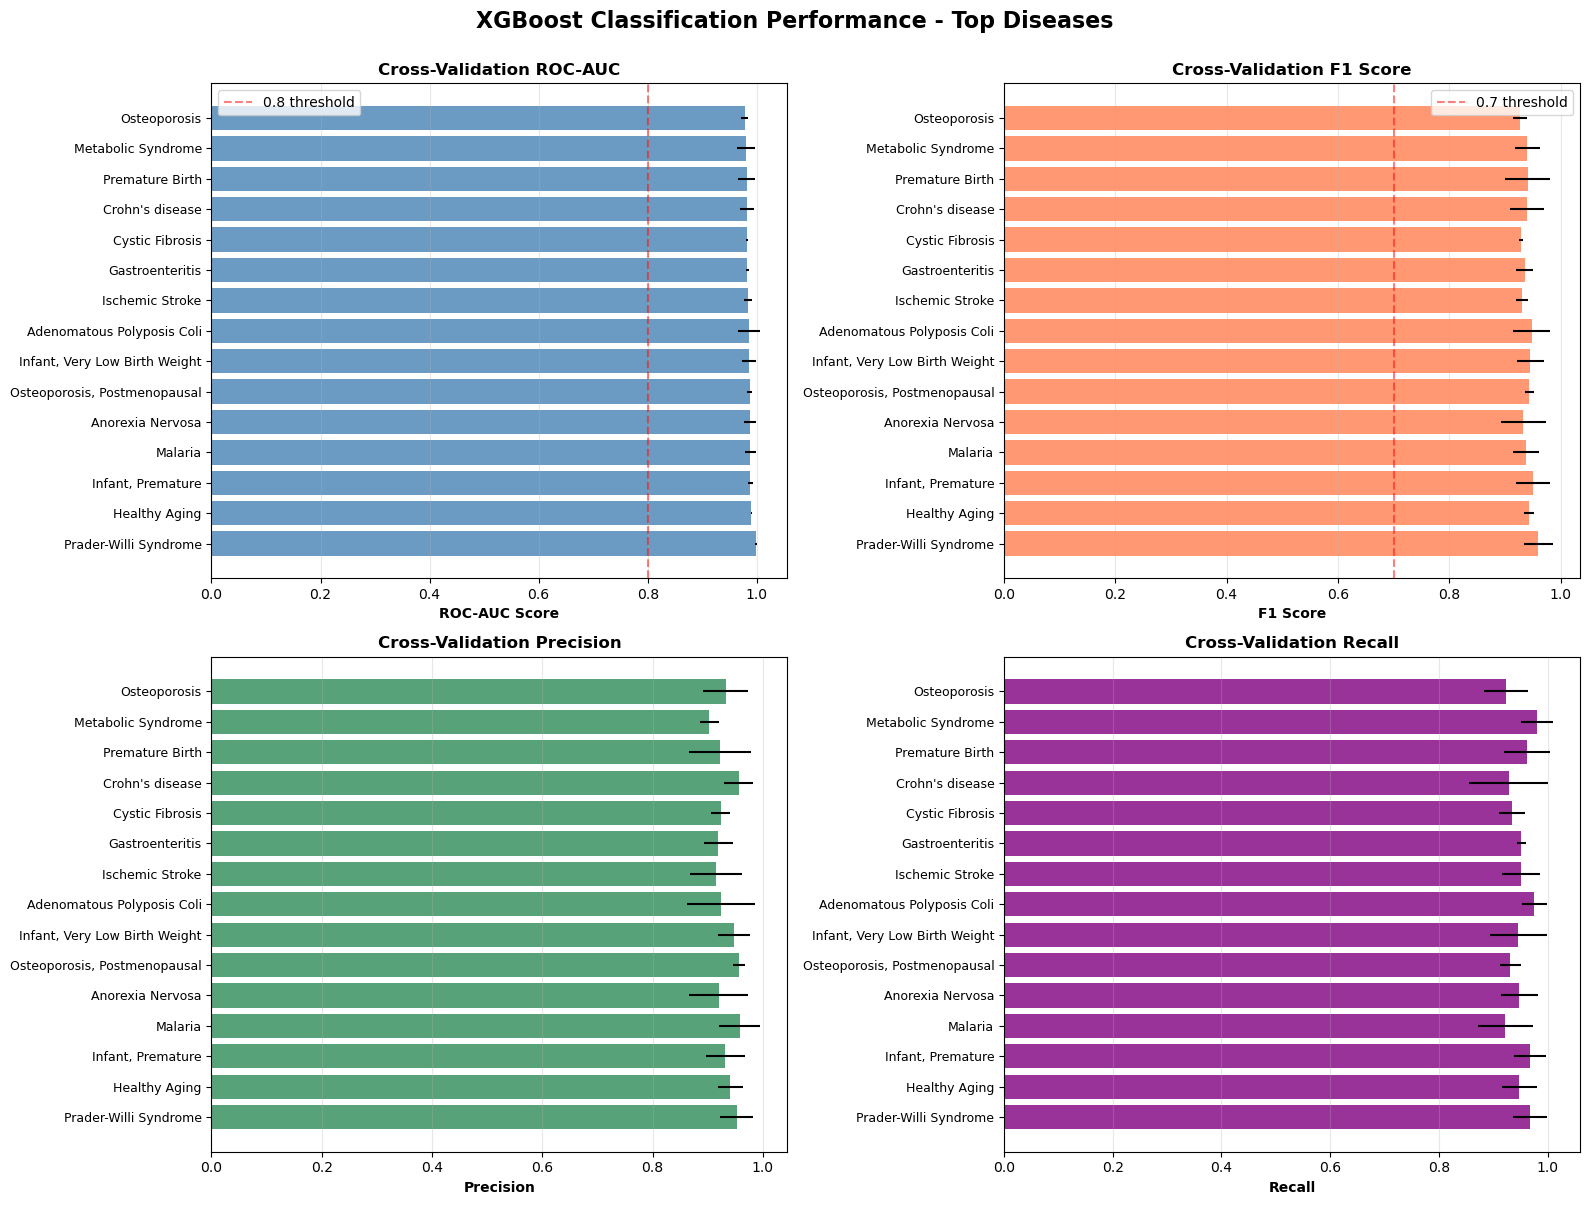

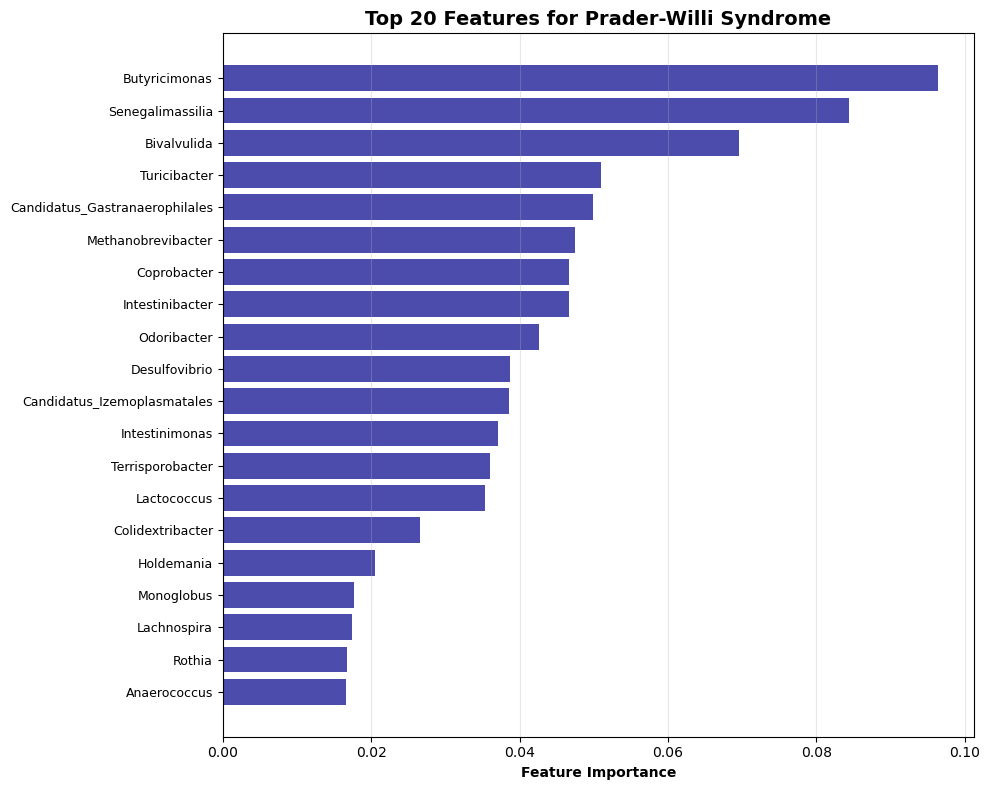

In [30]:
# ============================================================================
# 8. RESULTS ANALYSIS
# ============================================================================
print("\n[8/8] Analyzing results...")

results_df = pd.DataFrame(all_results)

# Save results
results_df.to_csv('xgboost_classification_results.csv', index=False)
print("✓ Saved: xgboost_classification_results.csv")

# Filter for good models (CV ROC-AUC > 0.70 and CV F1 > 0.60)
good_models = results_df[
    (results_df['CV_ROC_AUC_Mean'] > 0.70) & 
    (results_df['CV_F1_Mean'] > 0.60)
].copy()

print(f"\n✓ Found {len(good_models)} diseases with good classification performance")

if len(good_models) > 0:
    # Sort by ROC-AUC
    good_models = good_models.sort_values('CV_ROC_AUC_Mean', ascending=False)
    
    # Display top results
    print("\nTop 10 Best Classified Diseases:")
    print("="*80)
    display_cols = ['Disease', 'CV_ROC_AUC_Mean', 'CV_F1_Mean', 'CV_Precision_Mean', 'CV_Recall_Mean']
    print(good_models[display_cols].head(10).to_string(index=False))
    
    # ========================================================================
    # Visualization: Performance metrics
    # ========================================================================
    top_n = min(15, len(good_models))
    top_models = good_models.head(top_n)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # ROC-AUC
    axes[0, 0].barh(range(len(top_models)), top_models['CV_ROC_AUC_Mean'], 
                     xerr=top_models['CV_ROC_AUC_Std'], color='steelblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(top_models)))
    axes[0, 0].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[0, 0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0, 0].set_title('Cross-Validation ROC-AUC', fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].axvline(0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
    axes[0, 0].legend()
    
    # F1 Score
    axes[0, 1].barh(range(len(top_models)), top_models['CV_F1_Mean'], 
                     xerr=top_models['CV_F1_Std'], color='coral', alpha=0.8)
    axes[0, 1].set_yticks(range(len(top_models)))
    axes[0, 1].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[0, 1].set_xlabel('F1 Score', fontweight='bold')
    axes[0, 1].set_title('Cross-Validation F1 Score', fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].axvline(0.7, color='red', linestyle='--', alpha=0.5, label='0.7 threshold')
    axes[0, 1].legend()
    
    # Precision
    axes[1, 0].barh(range(len(top_models)), top_models['CV_Precision_Mean'], 
                     xerr=top_models['CV_Precision_Std'], color='seagreen', alpha=0.8)
    axes[1, 0].set_yticks(range(len(top_models)))
    axes[1, 0].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[1, 0].set_xlabel('Precision', fontweight='bold')
    axes[1, 0].set_title('Cross-Validation Precision', fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Recall
    axes[1, 1].barh(range(len(top_models)), top_models['CV_Recall_Mean'], 
                     xerr=top_models['CV_Recall_Std'], color='purple', alpha=0.8)
    axes[1, 1].set_yticks(range(len(top_models)))
    axes[1, 1].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[1, 1].set_xlabel('Recall', fontweight='bold')
    axes[1, 1].set_title('Cross-Validation Recall', fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.suptitle('XGBoost Classification Performance - Top Diseases', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('classification_performance_summary.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: classification_performance_summary.png")
    
    # ========================================================================
    # Feature importance for top disease
    # ========================================================================
    if len(good_models) > 0:
        top_disease = good_models.iloc[0]['Disease']
        top_features = feature_importance_dict[top_disease].head(20)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_features['importance'], color='darkblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
        plt.xlabel('Feature Importance', fontweight='bold')
        plt.title(f'Top 20 Features for {top_disease}', fontweight='bold', fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'feature_importance_{top_disease.replace("/", "_").replace(" ", "_")}.png', 
                    dpi=300, bbox_inches='tight')
        print(f"✓ Saved: feature importance plot for {top_disease}")


In [31]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Files Generated:")
print("  1. xgboost_classification_results.csv - Complete results for all diseases")
print("  2. healthy_samples_pca_umap.png - Visualization of healthy cohort")
print("  3. [disease]_pca_umap.png - PCA/UMAP for each disease")
print("  4. classification_performance_summary.png - Performance metrics overview")
print("  5. feature_importance_*.png - Top features for best disease")
print("\nSummary Statistics:")
print(f"  Total diseases analyzed: {len(results_df)}")
print(f"  Diseases with good performance (AUC>0.7, F1>0.6): {len(good_models)}")
if len(good_models) > 0:
    print(f"  Best disease: {good_models.iloc[0]['Disease']}")
    print(f"  Best ROC-AUC: {good_models.iloc[0]['CV_ROC_AUC_Mean']:.4f}")
    print(f"  Best F1: {good_models.iloc[0]['CV_F1_Mean']:.4f}")
print("="*80)


ANALYSIS COMPLETE!

Key Files Generated:
  1. xgboost_classification_results.csv - Complete results for all diseases
  2. healthy_samples_pca_umap.png - Visualization of healthy cohort
  3. [disease]_pca_umap.png - PCA/UMAP for each disease
  4. classification_performance_summary.png - Performance metrics overview
  5. feature_importance_*.png - Top features for best disease

Summary Statistics:
  Total diseases analyzed: 62
  Diseases with good performance (AUC>0.7, F1>0.6): 62
  Best disease: Prader-Willi Syndrome
  Best ROC-AUC: 0.9980
  Best F1: 0.9593
